# **RoBERTa Fine-tuning**

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        pass

/kaggle/input/final_cleaned (1).csv


In [3]:
import pandas as pd
import numpy as np

In [4]:
df = pd.read_csv("/kaggle/input/final_cleaned (1).csv")
df.head()

,text,label,prompt_name,source
0,Phones Modern humans today are always on their...,0,Phones and driving,persuade_corpus
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus
2,Driving while the use of cellular devices Toda...,0,Phones and driving,persuade_corpus
3,Phones & Driving Drivers should not be able to...,0,Phones and driving,persuade_corpus
4,Cell Phone Operation While Driving The ability...,0,Phones and driving,persuade_corpus


In [5]:
df = df[['text','label']]

In [6]:
df.head()

,text,label
0,Phones Modern humans today are always on their...,0
1,This essay will explain if drivers should or s...,0
2,Driving while the use of cellular devices Toda...,0
3,Phones & Driving Drivers should not be able to...,0
4,Cell Phone Operation While Driving The ability...,0


In [7]:
from sklearn.model_selection import train_test_split

# Define outcome name
outcomename = 'label'

# Redefine X and Y after sampling
X = df.drop(columns=outcomename)
y = df[outcomename]

# Split into training and combined validation-test sets (80% train, 20% valid/test)
X_train, X_valid_test, y_train, y_valid_test = train_test_split(X, y, test_size=0.2, random_state=20240917, stratify=y)

# Split the combined validation-test set into separate validation and test sets (50% each of the remaining 20%)
X_val, X_test, y_val, y_test = train_test_split(X_valid_test, y_valid_test, test_size=0.5, random_state=20240917, stratify=y_valid_test)

In [8]:
X_train

,text
56635,"“A Cowboy Who Rode the Waves,” tells the story..."
60101,Mobile Phones & Vehicle Operation It should be...
37897,"Dear Principal Smith, I am writing to share my..."
64644,It is no secret that car usage is one of the m...
7600,""" Should or shouldn't students participate in ..."
...,...
58725,“Making Mona Lisa Smile” is a compelling artic...
6710,"I agree, students should participate in after ..."
19032,The voters of America do not vote for a presid...
63290,"In recent decades, the number of cars on the r..."


In [9]:
y_train

56635    1
60101    1
37897    1
64644    1
7600     0
        ..
58725    1
6710     0
19032    0
63290    1
45826    1
Name: label, Length: 52262, dtype: int64

In [10]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(52262, 1)
(6533, 1)
(6533, 1)
(52262,)
(6533,)
(6533,)


In [11]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments

model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2)
tokenizer = RobertaTokenizer.from_pretrained("FacebookAI/roberta-base")

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [12]:
import torch
from torch.utils.data import Dataset

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        text = self.texts.iloc[index]
        label = self.labels.iloc[index]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }



train_dataset = CustomDataset(X_train['text'], y_train, tokenizer)
val_dataset = CustomDataset(X_val['text'], y_val, tokenizer)
test_dataset = CustomDataset(X_test['text'], y_test, tokenizer)

In [13]:
import torch

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU not available. Using CPU instead.")

model.to(device)

GPU is available. Using GPU: Tesla P100-PCIE-16GB


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [14]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [15]:
!pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.1 MB/s eta 0:00:00


In [16]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

In [17]:
from transformers import set_seed, Trainer

# Set the seed for reproducibility
set_seed(20240917)

In [18]:
# Don't Show Warning Messages
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["WANDB_DISABLED"] = "true"

In [19]:
import csv
from sklearn.metrics import accuracy_score
from transformers import TrainerCallback, Trainer

# Define the CSVLogger class
class CSVLogger(TrainerCallback):
    def __init__(self, filename="training_log.csv"):
        self.filename = filename
        with open(self.filename, mode='w') as file:
            writer = csv.writer(file)
            writer.writerow(["epoch", "step", "training_loss", "validation_loss", "training_accuracy", "validation_accuracy", "learning_rate"])  # Header row

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is None:
            return
        # Log training loss and learning rate
        with open(self.filename, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([state.epoch, state.global_step, logs.get("loss", None), None, logs.get("training_accuracy", None), None, logs.get("learning_rate", None)])

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics is None:
            return
        # Log validation loss and validation accuracy
        with open(self.filename, mode='a') as file:
            writer = csv.writer(file)
            writer.writerow([state.epoch, state.global_step, None, metrics.get("eval_loss", None), None, metrics.get("eval_accuracy", None), None])

In [20]:
def model_init() :
    return  RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base", num_labels=2)

In [21]:
training_args = TrainingArguments(
    eval_strategy="epoch",
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    save_strategy="epoch",               
    load_best_model_at_end=True,         
    metric_for_best_model="eval_accuracy",    
    greater_is_better=True, 
    seed = 20240917 
)

# Initialize Trainer
trainer = Trainer(
    model_init = model_init,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer = tokenizer,
    compute_metrics=compute_metrics,
     callbacks=[CSVLogger(filename="training_log.csv")]
)

# Fine-tune the model
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.029000,0.050920,0.992040
2,0.011500,0.025467,0.995867
3,0.011300,0.014175,0.997092
4,0.000600,0.029411,0.994949
5,0.000800,0.049760,0.992959


TrainOutput(global_step=16335, training_loss=0.014240058927583264, metrics={'train_runtime': 15739.3929, 'train_samples_per_second': 16.602, 'train_steps_per_second': 1.038, 'total_flos': 6.87535498761216e+16, 'train_loss': 0.014240058927583264, 'epoch': 5.0})

In [22]:
from torch.utils.data import DataLoader

# Assuming you've already created your test_dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [23]:
import torch
import numpy as np

model.eval()  # Set the model to evaluation mode
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predictions = torch.max(outputs.logits, dim=1)

        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
y_pred = np.array(all_predictions)
y_true = np.array(all_true_labels)

              precision    recall  f1-score   support

           0       0.42      1.00      0.59      2737
           1       0.00      0.00      0.00      3796

    accuracy                           0.42      6533
   macro avg       0.21      0.50      0.30      6533
weighted avg       0.18      0.42      0.25      6533



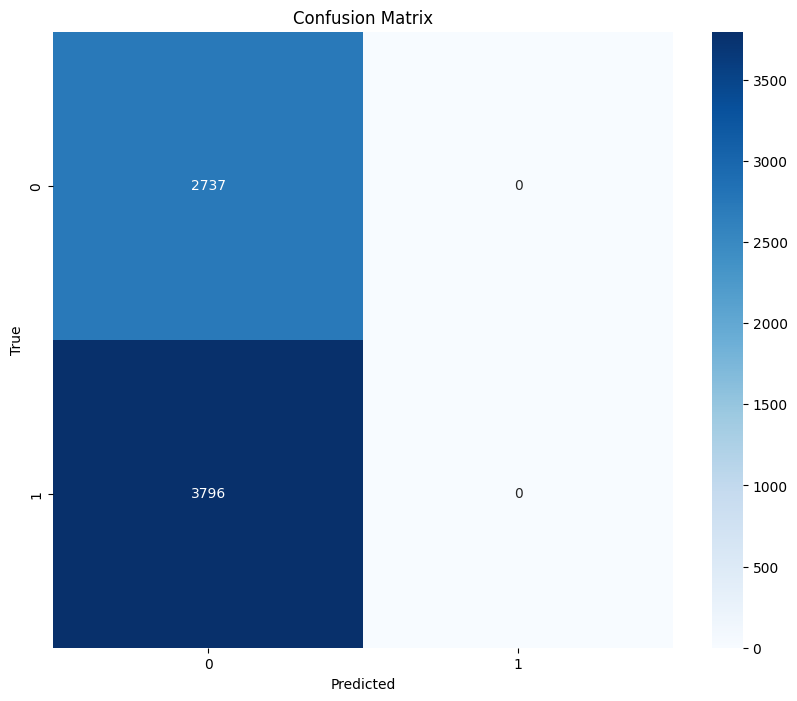

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Print classification report
print(classification_report(y_true, y_pred))

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()